In [1]:
!pip install opendatasets librosa soundfile

## Import Library

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/franciscoaliss/music-instrument-stems")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bondantm
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/franciscoaliss/music-instrument-stems


100%|██████████| 912M/912M [00:04<00:00, 217MB/s]


In [3]:
import os
import librosa
import soundfile as sf

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
acoustic_guitar_dir = '/content/music-instrument-stems/mega_augmented_ds/mega_augmented_ds/Acoustic Guitar'
piano_dir = '/content/music-instrument-stems/mega_augmented_ds/mega_augmented_ds/Piano'

audio_data = []
labels = []

def load_audio_data(directory, label):
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            try:
                # Load audio file
                data, sample_rate = librosa.load(filepath)
                audio_data.append(data)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

load_audio_data(acoustic_guitar_dir, 'Acoustic Guitar')
load_audio_data(piano_dir, 'Piano')

# You can now process the audio_data and labels further as needed
print(f"Loaded {len(audio_data)} audio files.")
print(f"Labels: {np.unique(labels)}")

Loaded 2128 audio files.
Labels: ['Acoustic Guitar' 'Piano']


## Feature extraction

### Alasan:
Mengambil fitur yang relevan dari data audio yang telah dimuat, khususnya Mel-Frequency Cepstral Coefficients (MFCCs).


In [5]:
features = []
for data in audio_data:
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=data, sr=22050) # Using default sample rate of librosa
    # Calculate the mean of MFCCs across the time axis
    mfccs_processed = np.mean(mfccs.T, axis=0)
    features.append(mfccs_processed)

# Convert the features list to a NumPy array
features = np.array(features)

print(f"Extracted features shape: {features.shape}")

Extracted features shape: (2128, 20)


## Under sampling

### Alasan:
Memeriksa dan menyeimbangkan distribusi jumlah sampel di antara kelas-kelas target (yaitu, kelas "Gitar" dan kelas "Piano") menggunakan teknik undersampling.


In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
print("Label distribution before undersampling:")
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count}")

# Check for imbalance (e.g., if the ratio between the largest and smallest class is significant)
if counts.max() / counts.min() > 1.5: # Using a threshold of 1.5 as an example for imbalance
    print("\nDataset is imbalanced, applying undersampling.")
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    features_resampled, labels_resampled = rus.fit_resample(features, labels)
    features = features_resampled
    labels = labels_resampled
    print("Label distribution after undersampling:")
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count}")
else:
    print("\nDataset is balanced or the imbalance is not significant enough for undersampling.")


Label distribution before undersampling:
Acoustic Guitar: 836
Piano: 1292

Dataset is imbalanced, applying undersampling.
Label distribution after undersampling:
Acoustic Guitar: 836
Piano: 836


## Data splitting

### Alasan:
Pembagian data memastikan model belajar dari satu set data dan diuji keandalannya pada set data lain, sementara konversi label memastikan data berada dalam format numerik yang efisien untuk komputasi model.


In [7]:
y_labels_array = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(features, y_labels_array, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1337, 20)
Shape of X_test: (335, 20)
Shape of y_train: (1337,)
Shape of y_test: (335,)


## Label Encoding

### Alasan:
mengubah label kategori yang berupa teks atau string (misalnya, 'Gitar Akustik', 'Piano') menjadi format numerik (misalnya, 0 dan 1).


In [8]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Unique values in y_train_encoded:", np.unique(y_train_encoded))
print("Unique values in y_test_encoded:", np.unique(y_test_encoded))
print("Mapping of labels:", list(le.classes_))


Unique values in y_train_encoded: [0 1]
Unique values in y_test_encoded: [0 1]
Mapping of labels: [np.str_('Acoustic Guitar'), np.str_('Piano')]


## Prepare features for MobileNetV2

### Alasan:
Mengubah fitur MFCC yang telah diekstrak (data audio) menjadi format yang dapat diproses oleh arsitektur MobileNetV2, yang pada dasarnya adalah model klasifikasi gambar.

In [9]:
TARGET_HEIGHT = 96
TARGET_WIDTH = 96
TARGET_CHANNELS = 3 # MobileNetV2 expects 3 channels (RGB)

def prepare_features_for_mobilenet(features, target_h, target_w, target_c):
    # Reshape from (num_samples, 20) to (num_samples, 20, 1, 1)
    # This treats each sample's 20 features as a 20x1 "image" with 1 channel
    reshaped_features = features[:, :, np.newaxis, np.newaxis] # Shape (num_samples, 20, 1, 1)

    current_height = reshaped_features.shape[1] # 20
    current_width = reshaped_features.shape[2] # 1

    pad_h = target_h - current_height
    pad_w = target_w - current_width

    if pad_h < 0 or pad_w < 0:
        # This should not happen with TARGET_HEIGHT=96, TARGET_WIDTH=96 and current dimensions (20,1)
        raise ValueError("Target dimensions must be greater than or equal to current dimensions.")

    # Pad height and width with zeros to reach target_h and target_w
    # The padding is applied symmetrically (0 before, pad_h/pad_w after) to fill the space
    padded_features = np.pad(reshaped_features,
                             ((0, 0), (0, pad_h), (0, pad_w), (0, 0)),
                             mode='constant',
                             constant_values=0)
    # Shape after padding: (num_samples, target_h, target_w, 1)

    # Replicate the single channel to 3 channels (RGB) by repeating along the last axis
    final_features = np.repeat(padded_features, target_c, axis=-1)
    # Shape after replication: (num_samples, target_h, target_w, target_c)

    return final_features

X_train_processed = prepare_features_for_mobilenet(X_train, TARGET_HEIGHT, TARGET_WIDTH, TARGET_CHANNELS)
X_test_processed = prepare_features_for_mobilenet(X_test, TARGET_HEIGHT, TARGET_WIDTH, TARGET_CHANNELS)

print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")

Shape of X_train_processed: (1337, 96, 96, 3)
Shape of X_test_processed: (335, 96, 96, 3)


## Build MobileNetV2-based Classifier

### Alasan:
Membangun model klasifikasi dengan menggunakan arsitektur MobileNetV2 yang sudah dilatih (pre-trained) sebagai kerangka dasar, dan kemudian memodifikasi lapisan akhirnya agar sesuai dengan tugas klasifikasi biner Anda (Gitar vs. Piano).

In [10]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_HEIGHT, TARGET_WIDTH, TARGET_CHANNELS))

# Add custom classification layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # Additional dense layer for more capacity (optional)
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained MobileNetV2 base model
for layer in base_model.layers:
    layer.trainable = False

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile and Train the Model

### Alasan:
Tahap implementasi inti, di mana model MobileNetV2 yang sudah dimodifikasi disiapkan (dikompilasi) dan diajarkan (dilatih) menggunakan data fitur MFCC yang sudah disiapkan.

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_processed, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test_processed, y_test_encoded))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - accuracy: 0.5490 - loss: 1.2447 - val_accuracy: 0.7104 - val_loss: 0.5616
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.7359 - loss: 0.5300 - val_accuracy: 0.8060 - val_loss: 0.4625
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.8328 - loss: 0.4219 - val_accuracy: 0.8358 - val_loss: 0.4507
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7975 - loss: 0.4491 - val_accuracy: 0.8418 - val_loss: 0.3958
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8408 - loss: 0.3858 - val_accuracy: 0.8269 - val_loss: 0.3766
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.8406 - loss: 0.3915 - val_accuracy: 0.7642 - val_loss: 0.5112
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.8388 - loss: 0.3545 - val_accuracy: 0.8657 - val_loss: 0.3428
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8374 - loss: 0.3721 - val_accu

## Evaluation Model

### Alasan:


1.   Memvisualisasikan bagaimana model belajar dan mendeteksi masalah umum seperti overfitting atau underfitting.
2.   Memberikan gambaran visual yang jelas mengenai jumlah prediksi yang benar dan salah untuk setiap kelas secara terperinci.
3.   Menghitung dan menyajikan metrik evaluasi kinerja kunci (Precision, Recall, F1-Score) untuk setiap kelas secara terpisah, memberikan pandangan yang lebih mendalam daripada hanya akurasi.



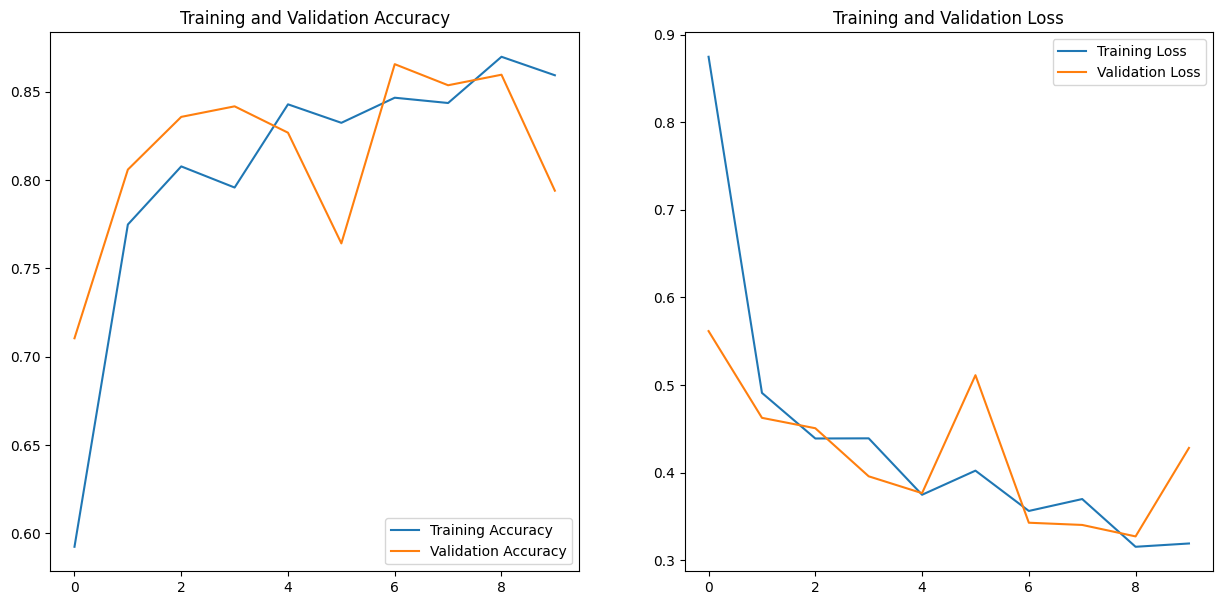

In [20]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step


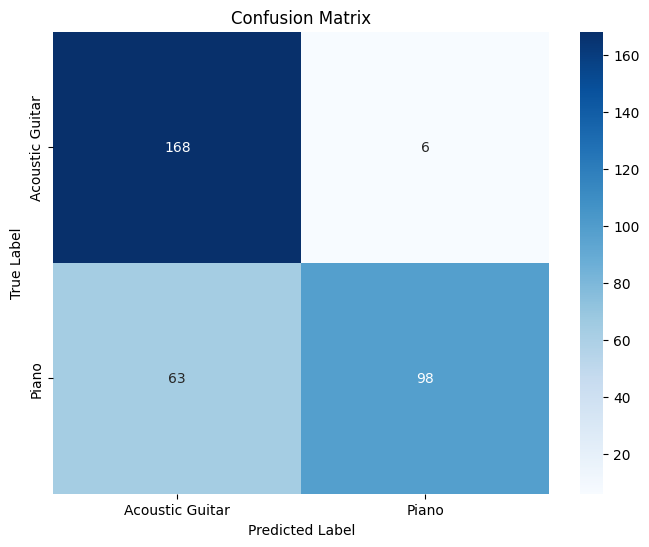

In [23]:
# Get predictions on the test set
y_pred_probabilities = model.predict(X_test_processed)
y_pred_encoded = (y_pred_probabilities > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# Get class names from LabelEncoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=class_names))

Classification Report:
                 precision    recall  f1-score   support

Acoustic Guitar       0.73      0.97      0.83       174
          Piano       0.94      0.61      0.74       161

       accuracy                           0.79       335
      macro avg       0.83      0.79      0.78       335
   weighted avg       0.83      0.79      0.79       335

